<a href="https://colab.research.google.com/github/lphansen/RiskUncertaintyValue/blob/main/continuous_elasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shock Elasticities: Continuous Time

Shock elasticities quantify the (local) exposures of macroeconomic cash flows to shocks over alternative investment horizons and the corresponding prices or investors’ compensations. This Jupyter notebook provides the computations for the shock elasticities for models with equilibrium outcomes represented as a continuous-time diffusion. This notebook implements methods and formulas developed in [[1]](https://link.springer.com/article/10.1007/s11579-014-0122-4) and [[2]](https://onlinelibrary.wiley.com/doi/abs/10.3982/ECTA8070).

- Section 1 gives the continuous-time formulation with a Brownian motion information structure.    
- Section 2 provides an illustration using an intermediary asset pricing model, see [[3]](https://www.aeaweb.org/articles?id=10.1257/aer.104.2.379), [[4]](https://www.sciencedirect.com/science/article/abs/pii/S1574004816300155), and [[5]](https://www.zccfe.uzh.ch/dam/jcr:c4a09093-fc00-4953-9f31-701dc0cd3fab/macro-model-print.pdf). 

Please refer to the following paper for further details

["Term Structure of Uncertainty in the Macroeconomy” joint research with Jaroslav Borovička – Handbook of Macroeconomics](https://larspeterhansen.org/wp-content/uploads/2016/10/macroterm_main.pdf) 

And also refer to

["Examining Macroeconomic Models Through the Lens of Asset Pricing” joint research with Jaroslav Borovička – Journal of Econometrics](https://larspeterhansen.org/wp-content/uploads/2016/10/Examining-Macroeconomic-Models-through-the-Lens-of-Asset-Pricing.pdf) 

["Shock elasticities and impulse responses" joint research with Jaroslav Borovička and José A. Scheinkman - Mathematics and Financial Economics](https://link.springer.com/article/10.1007/s11579-014-0122-4)



In [1]:
import os
import sys
workdir = os.getcwd() 
# !git clone https://github.com/lphansen/RiskUncertaintyValue # Please uncomment this line when running on the google colab
# workdir = os.getcwd() + '/RiskUncertaintyValue'             # Please uncomment this line when running on the google colab
sys.path.insert(0, workdir+'/src')
from IPython.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))
import numpy as np
np.set_printoptions(suppress=True)
from scipy.interpolate import RegularGridInterpolator
from scipy import interpolate
# !pip install pyMKL # Please uncomment this line when running on the google colab
from shockElasModules import computeElas
from stationaryDensityModules import computeDent
import pickle
import itertools
import json

# 1. Continuous-time framework

## 1.1 Basic setup
Suppose a continuous-time diffusion model:

$$
\begin{align}
dX_t & = \mu_X(X_t)dt + \sigma_X(X_t) dW_t \tag{1}\cr
dM_t & = M_t \mu_M(X_t)dt + M_t \sigma_M(X_t) dW_t \notag\cr 
dY_t &= \mu_M(X_t)dt - \frac 1 2 \vert\sigma_M (X_t)\vert^2  + \sigma_M (X_t) dW_t\notag
\end{align}
$$

where $X$ is an $n$-dimensional process and $W$ is an $m$-dimensional Brownian motion and 
$Y = \log M.$

The two types of shock elasticities of interest are:

$$
\begin{align}
\epsilon_M(x) &= \nu(x)\cdot \left[ {\sigma_X(x)}' \left(\frac {\partial}{\partial x}\log {\mathbb E}\left[ \left(
\frac {M_t}{M_0}\right)  \mid X_0 = x \right] \right) + \sigma_M(x) \right] \label{eq:shock1}\tag{2}\cr
{\epsilon}_M^+(x) & = \frac{{\mathbb E}\left[ \left(
\frac {M_t}{M_0}\right) \nu(X_t) \cdot \sigma_M(X_t)  \mid X_0 = x \right] }
{{\mathbb E}\left[ \left(
\frac {M_t}{M_0}\right) \mid X_0 = x \right]} \tag{3}
\end{align}
$$

The code computes 

$$
\begin{align}
&{\mathbb E}\left[ \left(
\frac {M_t}{M_0}\right)  \mid X_0 = x \right]  \tag{4} \\
&{\mathbb E}\left[ \left(
\frac {M_t}{M_0}\right) \nu(X_t)  \cdot \sigma_M(X_t)  \mid X_0 = x \right] \tag{5}
\end{align}
$$

by using the Feynman_Kac formula. Define

$$
\begin{align}
\phi_t(x) = {\mathbb E}\left[ \left(
\frac {M_t}{M_0}\right) \phi_0(X_t)   \mid X_0 = x \right]\tag{6}.
\end{align}
$$

Then $\phi_t$ satisfies:

$$
\begin{align} 
\frac {\partial \phi}{\partial t} = & \mu_M \phi  
+  \left(\mu_X  + \sigma_X {\sigma_M}' \right) \cdot \frac {\partial \phi}{\partial x} \notag\cr
& + {\frac 1 2} {\rm trace}
\left\{ {\sigma_X}' \left( \frac {\partial^2 \phi }{\partial  xx'} \right) {\sigma_X} \right\}\tag{7}
\end{align}
$$

where $\phi_0 = 1$ for (4) and $\phi_0 = \nu \cdot \sigma_M$ for (5).  



## 1.2 Stochastic discount factor process

Represent the stochastic discount factor evolution and the evolution of its logarithm as:

$$
\begin{align}
d S_t & = S_t \mu_S(X_t) dt + S_t \sigma_S(X_t) dW_t \notag\cr
d \log S_t & = {\hat \mu}_S(X_t) dt  + \sigma_S(X_t) dW_t.\tag{8}
\end{align}
$$

where ${\hat \mu}_S(X_t) =  \mu_S(X_t) - \frac 1 2 \vert \sigma_S(X_t) \vert^2.$  The instantaneous risk-free rate is 
$- \mu_S(X_t)$ and the local price vector for exposure to the Brownian increment is $-\sigma_S(X_t).$

Also represent the consumption and continuation value evolution and the evolution of their logarithm as:

$$
\begin{align}
d C_t & = C_t \mu_C(X_t) dt + C_t \sigma_C(X_t) dW_t \notag \cr 
d \log C_t & = \mu_C(X_t) dt - \frac 1 2 \vert \sigma_C(X_t) \vert^2 dt + \sigma_C(X_t) dW_t \tag{9}\cr 
d V_t & = V_t \mu_V(X_t) dt + V_t \sigma_V(X_t) dW_t \notag \cr
d \log V_t & = \mu_V(X_t) dt - \frac 1 2 \vert \sigma_V(X_t) \vert^2 dt + \sigma_V(X_t) dW_t \notag.  
\end{align}
$$

where ${\hat \mu}_C(X_t) =  \mu_C(X_t) - \frac 1 2 \vert \sigma_C(X_t) \vert^2$ and ${\hat \mu}_V(X_t) =  \mu_V(X_t) - \frac 1 2 \vert \sigma_V(X_t) \vert^2.$    

The code computes the evolutions in terms of logarithms for reasons of numerically convenient.  
Given the consumption and continuation-value evolution, 

$$
\begin{align}
{\hat \mu}_S(X_t)  & = - \delta - \rho {\hat \mu}_C(X_t) + \frac {(\gamma - 1)(\rho - \gamma) } 2 \vert \sigma_V(X_t) \vert^2 \cr
\sigma_S(X_t) & = - \rho \sigma_C(X_t) + (\rho - \gamma) \sigma_V(X_t)
\end{align} 
$$

where

$$
\begin{align}
\delta & = \textrm{subjective rate of discount} \cr
\rho & = \textrm{reciprocal of the intertemporal elasticity of substitution} \cr
\gamma & = \textrm{risk aversion or aversion to model misspecification} 
\end{align} 
$$

The martingale uncertainty contribution to the stochastic discount factor process and the evolution of its  logarithmic counterpart are of particular interest.

$$
\begin{align}
dN_t & = N_t \sigma_N(X_t) dW_t \cr
d \log N_t &= - \frac 1 2 \vert \sigma_N(X_t) \vert^2 dt + \sigma_N(X_t) dW_t
\end{align}
$$

where 

$$
\begin{align}
\sigma_N(X_t)= (1 - \gamma) \sigma_V(X_t) .
\end{align}
$$

Use $N$ in place of $S$ to obtain the uncertainty component to the shock price elasticities.  

## 1.3 Shock Exposure Elasticity and Price Elasticity
For this continuous-time setup, the code computes the shock exposure elasticity or impulse response function for a process, $G$, using formula \eqref{eq:shock1} and \eqref{eq:shock2}, the corresponding shock price elasticity using 

$$
\begin{align}
& \varepsilon_G(x, t)-\varepsilon_{SG}(x, t) \\
& \varepsilon_G^+(x, t)-\varepsilon_{SG}^+(x, t)
\end{align}
$$



# 2. An Illustration using an intermediary asset pricing model [3], [4], [5]

## 2.1  Computing Shock Elasticities: `computeElas`
`computeElas` is the function that computes the shock exposure and price elasticities (both the first and second types). It takes in the following arguments:

`stateMat`: (Tuple) 
- A tuple containing a numpy-array formatted domain for each of the states. For example, suppose the model has two state variables and each state variable has 100 grid points. The stateMat argument would be a tuple containing two numpy arrays of shape $(100$,$) .$

`model`:(Dictionary) 
- A dictionary that contains the information described in (1), (8), and (9). Specifically, it has the following keys:

    `muX`: (Function) 
    - A function that computes the drifts of the state variables (i.e. $\mu_X$ as in (1)) for each of the grid points in stateMat. Suppose there are $n$ state variables. Given a $k \times n$ numpy matrix points, where each row represents a point, `model['muX'](points)` must return a $k \times n$ numpy matrix, with each row corresponding to the drift vector of the state variables.

    `sigmaX`: 
    - (List of functions) A list of functions, where each function computes the diffusion of a state variable (i.e. $\sigma_X$ as in (1)) in order of the list (i.e. the first element of the list computes the diffusion of the first state variable in stateMat). For example, suppose there are $n$ state variables and $m$ shocks. `model['sigmaX']` is a list of two elements. Further suppose that points is a $k \times n$ matrix, where each row represents a point. Then `model['sigmaX'][0](points)` returns a $k \times m$ matrix that contains the diffusion of the first state variable at these points.

    `muC`: (Function) 
    - Similar to muX, a function that computes $\mu_C$, the drift of the perturbed process, as in (9). Suppose there are $n$ state variables. `model['muC'](points)` must return a $k \times 1$ numpy matrix, where points is a $k \times n$ matrix. Note: the number of columns of points is $n$, but the dimensions of the output are $k \times 1$. Note that $C$ is not limited to consumption process. It could be a general process $G$ as shown in section 2.3. 

    `sigmaC`: (Function) 
    - A function that computes $\sigma_C$, the diffusion of the perturbed process, as in (9). Suppose points is a $k \times n$ matrix. Then `model['sigmaC'](points)` must return a $k \times m$ matrix, where $n$ is the number of state variables and $m$ is the number of shocks (Note that $m$ is not necessarily equal to $n$ ). Note that $C$ is not limited to consumption process. It could be a general process $G$ as shown in section 2.3. 

    `muS`: (Function) 
    - Similar to muX and muC, a function that computes $\mu_S$, the drift of the stochastic discount factor, as in (6). Using the same example, `model['muS'](points)` must return a $k \times 1$ numpy matrix, where points is a $k \times n$ matrix.

    `sigmaS`: (Function) 
    - A function that computes $\sigma_S$, the diffusion of the perturbed process, as in (6). Suppose points is a $k \times n$ matrix. Then `model['sigmaS'](points)` must return a $k \times m$ matrix, where $n$ is the number of state variables and $m$ is the number of shocks.

    `dt`: (Float) 
    - The length of time step;

    `T`: (Integer) 
    - Total number of time periods. Suppose `dt` =1/12 implies one month and `model['T']`=120. The total time that the elasticities are solved for is 10 years.

`bc`: (Dictionary) 
- A dictionary that specifies the boundary conditions in this form:
$$
0=a_0+a_1\phi+a_2 \cdot \frac{\partial}{\partial x'}\phi \label{eq:what}\tag{10}
$$
for all $t$  
where $a_0, a_1$ are scalars,  and  $a_2$ is a  $1 \times n$ vectors. The user should configure `bc` in this way:
- `a0`: a scalar that corresponds to $a_0$ in \eqref{eq:what}
- `level`: a scalar that corresponds to $a_1$ in \eqref{eq:what}
- `first`: a $1 \times n$ numpy matrix that corresponds to $a_2$ in \eqref{eq:what}
- `natural`: a boolean (True or False) that determines whether to use natural boundaries; if True, the fields above would be ignored.   ``Natural boundaries'' are implemented by effectly assuming constant second derivatives at boundaries.  

For example, to implement the boundary conditions $0= \begin{bmatrix} 1 & 1 & 1 \end{bmatrix} \cdot  \frac{\partial}{\partial x} \phi$, one should set up bc by doing:



In [2]:
bc = {}
bc['a0']  = 0
bc['first'] = np.matrix([1, 1, 1], 'd')
bc['level'] = np.matrix([0])
bc['natural'] = False

`x0` : (numpy matrix) 
- A numpy matrix that contains all the starting points (i.e. $x$ in (6)). For $l$ starting points, $\mathrm{x} 0$ should be an $l \times n$ matrix ( $n$ being the number of states).

`usePardiso`: (Boolean) 
- A boolean option to use the Intel package called Pardiso to solve the linear system. Defaults to False.

`iparms`: (Dictionary) 
- If usePardiso is set to True, Pardiso's default parameters will be used. The iparms parameter allows the user to input a dictionary with changes for those default parameters. Note that while the Pardiso site indexes the parameters at one, this function argument indexes them at zero. For example, a user wishing to set what is listed on the website as iparm(1) to $-1$ would set iparms $=\{0:-1\}$.

Finally, we have one optional argument:

`betterCP`: (Boolean) 
- True by default. If False, the program will use the following finite difference approximation scheme for cross partials:

$$
\begin{align}
f_{x y}(x, y)=\frac{f(x+h, y+k)-f(x+h, y-k)-f(x-h, y+k)+f(x-h, y-k)}{4 h k}
\end{align}
$$

if True, the program will use the alternative finite difference approximation for cross partials. With the alternative approximation, one can have a better chance of preserving monotonicity:

$$
\begin{align}
f_{x y}(x, y)= & \frac{1}{2 h k}(f(x+h, y+k)-f(x+h, y)-f(x, y+k) \\
& +2 f(x, y)-f(x-h, y)-f(x, y-k)+f(x-h, y-k))
\end{align}
$$

The function returns exposure and price elasticities. Suppose the user inputs $l$ starting points (i.e. $\mathrm{x} 0$ has $l$ rows) and $T$ time periods. Then the function will return the following:

`expoElas`: 
- an object with two attributes: the firstType and secondType. Each attribute is an $l \times k \times T$ matrix. The first index corresponds to the starting point, the second index corresponds to the shock number, and the third corresponds to time. As the name suggests, firstType is the first type shock exposure elasticities for the $i$ th starting point (the $i$ th row in input $\mathrm{x} 0$ ) up to $T$ time periods, whereas secondType is the second type shock exposure elasticities.

`priceElas`: 
- similar to expoElas, but contains the price elasticities.

In [3]:
## modelsol includes the state variable grids, variable drift and diffusion term information from exogenous solutions
# 'muCe' stands for the drift term for Expert Consumption, 'muCh' stands for the drift term for Households Consumption
# 'sigmaCe' stands for the diffusion term for Expert Consumption, 'muCh' stands for the diffusion term for Households Consumption
# 'muSe' stands for the drift term for Expert SDF, 'muNe' stands for the drift term for Expert Uncertainty Component of SDF, 
# 'muX', stands for the drift term for state variables, wealth share (W), growth rate (Z), and stochastic volatility (V)
# The diffusion term and households have similar notation
# Please feel free to check the dimension of each element in modelsol
modelsol = pickle.load(open("RiskUncertaintyValue/data/model_ela_sol.pkl", "rb"))

# We compute the shock elasticities for 48 years with natural boundary
T = 48
dt = 1
bc = {'natural':True}

# The Toolbox takes python function as inputs, but usually the solution for drift and diffusion terms are the value evaluted at grid points, so we interpolate them as functions below.
muXs = []; stateVols = []
SDFeVols = []; SDFhVols = []
sigmaChVols = []; sigmaCeVols = []
sigmaNhVols = []; sigmaNeVols = []
stateVolsList = []; sigmaXs = []
commonInput = {}

# Iterate over state dimensions
for n in range(modelsol['nDims']):
    muXs.append(RegularGridInterpolator(modelsol['stateMatInput'],modelsol['muX'][:,n].reshape(modelsol['gridSizeList'], order = 'F')))
    if n == 0:
        commonInput['muCh'] = RegularGridInterpolator(modelsol['stateMatInput'], modelsol['muCh'].reshape(modelsol['gridSizeList'], order = 'F'))
        commonInput['muCe'] = RegularGridInterpolator(modelsol['stateMatInput'], modelsol['muCe'].reshape(modelsol['gridSizeList'], order = 'F'))
        commonInput['muSe'] = RegularGridInterpolator(modelsol['stateMatInput'], modelsol['muSe'].reshape(modelsol['gridSizeList'], order = 'F'))
        commonInput['muSh'] = RegularGridInterpolator(modelsol['stateMatInput'], modelsol['muSh'].reshape(modelsol['gridSizeList'], order = 'F'))
        commonInput['muNe'] = RegularGridInterpolator(modelsol['stateMatInput'], modelsol['muNe'].reshape(modelsol['gridSizeList'], order = 'F'))
        commonInput['muNh'] = RegularGridInterpolator(modelsol['stateMatInput'], modelsol['muNh'].reshape(modelsol['gridSizeList'], order = 'F'))
    # Iterate over shocks dimensions 
    for s in range(modelsol['nShocks']):
        stateVols.append(RegularGridInterpolator(modelsol['stateMatInput'], modelsol['sigmaX'][n][:,s].reshape(modelsol['gridSizeList'], order = 'F')))
        if n == 0:
            SDFeVols.append(RegularGridInterpolator(modelsol['stateMatInput'], modelsol['sigmaSe'][:,s].reshape(modelsol['gridSizeList'], order = 'F')))
            SDFhVols.append(RegularGridInterpolator(modelsol['stateMatInput'], modelsol['sigmaSh'][:,s].reshape(modelsol['gridSizeList'], order = 'F')))
            sigmaChVols.append(RegularGridInterpolator(modelsol['stateMatInput'], modelsol['sigmaCh'][:,s].reshape(modelsol['gridSizeList'], order = 'F')))
            sigmaCeVols.append(RegularGridInterpolator(modelsol['stateMatInput'], modelsol['sigmaCe'][:,s].reshape(modelsol['gridSizeList'], order = 'F')))
            sigmaNhVols.append(RegularGridInterpolator(modelsol['stateMatInput'], modelsol['sigmaNh'][:,s].reshape(modelsol['gridSizeList'], order = 'F')))
            sigmaNeVols.append(RegularGridInterpolator(modelsol['stateMatInput'], modelsol['sigmaNe'][:,s].reshape(modelsol['gridSizeList'], order = 'F')))
    stateVolsList.append(stateVols)
    def sigmaXfn(n):
        return lambda x: np.transpose([vol(x) for vol in stateVolsList[n] ])
    sigmaXs.append(sigmaXfn(n))
    stateVols = []
    if n == 0:
        commonInput['sigmaSe'] = lambda x: np.transpose([vol(x) for vol in SDFeVols])
        commonInput['sigmaSh'] = lambda x: np.transpose([vol(x) for vol in SDFhVols])
        commonInput['sigmaCe'] = lambda x: np.transpose([vol(x) for vol in sigmaCeVols])
        commonInput['sigmaCh'] = lambda x: np.transpose([vol(x) for vol in sigmaChVols])
        commonInput['sigmaNe'] = lambda x: np.transpose([vol(x) for vol in sigmaNeVols])
        commonInput['sigmaNh'] = lambda x: np.transpose([vol(x) for vol in sigmaNhVols])

commonInput['sigmaX'] = sigmaXs
commonInput['muX']    = lambda x: np.transpose([mu(x) for mu in muXs])
commonInput['T'] = T; commonInput['dt'] = dt;


In [4]:
%%time
## Below provides an example to use stationary distribution toolbox calculate the quantile of shock elasticities for state variable Wealth Share, the results for all three variables have been provided in the modelsol['x0']

# Form state grids using meshgrid
stateMat = tuple(modelsol['stateMatInput'])
stateGrid = np.meshgrid(*stateMat,  indexing='ij'); stateGrid = [np.matrix(x.flatten(order='F')).T for x in stateGrid]
stateGrid = np.concatenate(stateGrid, axis = 1)

## The `computeDent` takes similar input as shock elasticities toolbox, instead of function, we can directly input the drift and diffusion term evaluted at grid points with the form of np.matrix
dent = computeDent(stateGrid,{'muX': np.matrix(modelsol['muX']), 'sigmaX':[np.matrix(i) for i in modelsol['sigmaX']]}, bc = {'natural':True})

## Calculate Inverse CDFs
marginals = {}
inverseCDFs = {}
nRange   = list(range(modelsol['nDims']))
axes     = list(filter(lambda x: x != 0,nRange))
condDent = dent[0].reshape(modelsol['gridSizeList'], order = 'F').sum(axis = tuple(axes))
marginals['W'] = condDent.copy()
cumden   = np.cumsum(marginals['W'])
cdf      = interpolate.interp1d(cumden, modelsol['stateMatInput'][0], fill_value= (modelsol['stateMatInput'][0][1],  modelsol['stateMatInput'][0][-2]), bounds_error = False)
inverseCDFs['W'] = cdf

## Using Inverse CDFs to compute the median for the wealth share state variable
inverseCDFs['W'](0.5)

CPU times: user 23min 51s, sys: 5min 59s, total: 29min 51s
Wall time: 5min 28s


array(0.25329026)

In [5]:
%%time
## Compute shock elasticities for experts consumption
modelInput = commonInput.copy()
modelInput['sigmaC'] = commonInput['sigmaCe']
modelInput['muC']    = commonInput['muCe']
modelInput['sigmaS'] = commonInput['sigmaSe']
modelInput['muS']    = commonInput['muSe']

expoElasExperts, priceElasExperts, linSysExpo, linSysE = computeElas(modelsol['stateMatInput'], modelInput, bc, modelsol['x0'])

CPU times: user 56min 47s, sys: 14min 52s, total: 1h 11min 40s
Wall time: 14min 16s


In [6]:
%%time
## Compute shock elasticities for households consumption
modelInput = commonInput.copy()
modelInput['sigmaC'] = commonInput['sigmaCh']
modelInput['muC']    = commonInput['muCh']
modelInput['sigmaS'] = commonInput['sigmaSh']
modelInput['muS']    = commonInput['muSh']
expoElasHouseholds, priceElasHouseholds, linSysExpo, linSysH = computeElas(modelsol['stateMatInput'], modelInput, bc, modelsol['x0'])

CPU times: user 57min 48s, sys: 17min 19s, total: 1h 15min 8s
Wall time: 16min 48s


In [7]:
%%time
## Compute uncertain component for experts consumption using N instead of S 
modelInput = commonInput.copy()
modelInput['sigmaC'] = commonInput['sigmaCe']
modelInput['muC']    = commonInput['muCe']
modelInput['sigmaS'] = commonInput['sigmaNe']
modelInput['muS']    = commonInput['muNe']
expoElasExpertsN, priceElasExpertsN, linSysExpo, linSysE = computeElas(modelsol['stateMatInput'], modelInput, bc, modelsol['x0'])

CPU times: user 56min 44s, sys: 15min 52s, total: 1h 12min 36s
Wall time: 14min 56s


In [8]:
%%time
## Compute uncertain component for households consumption using N instead of S 
modelInput = commonInput.copy()
modelInput['sigmaC'] = commonInput['sigmaCh']
modelInput['muC']    = commonInput['muCh']
modelInput['sigmaS'] = commonInput['sigmaNh']
modelInput['muS']    = commonInput['muNh']
expoElasHouseholdsN, priceElasHouseholdsN, linSysExpo, linSysH = computeElas(modelsol['stateMatInput'], modelInput, bc, modelsol['x0'])

CPU times: user 1h 4s, sys: 17min 3s, total: 1h 17min 8s
Wall time: 16min 59s


## 2.2 Shock Elasticities Plots

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.options.display.float_format = '{:.3g}'.format
sns.set(font_scale = 1.5)
T = 48
# Calculate the shock elasticity at 0.25, 0.5 and 0.75 quantile for Stochastic Volatility
quantile = [0.25, 0.5, 0.75]

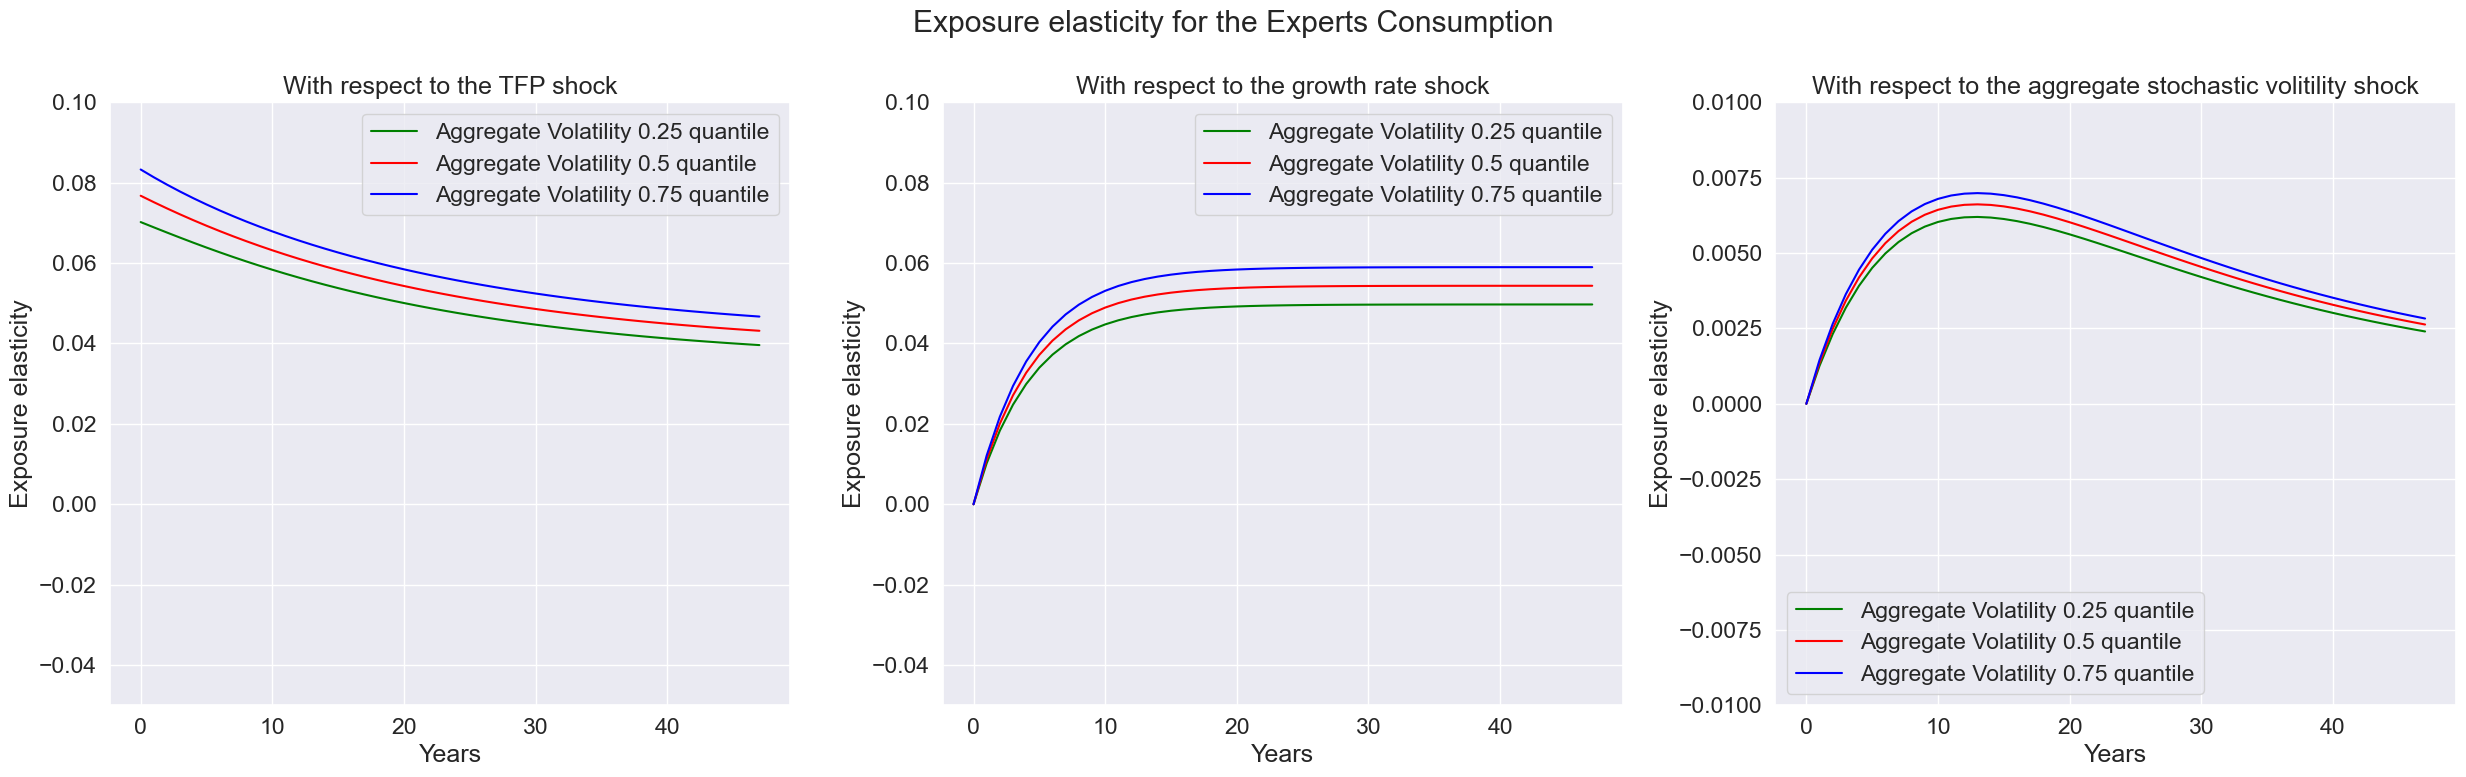

In [10]:
index = ['T','Aggregate Volatility 0.25 quantile','Aggregate Volatility 0.5 quantile','Aggregate Volatility 0.75 quantile']
fig, axes = plt.subplots(1,3, figsize = (25,8))
expo_elas_shock_0 = pd.DataFrame([np.arange(T),expoElasExperts.firstType[0,0,:],expoElasExperts.firstType[1,0,:],expoElasExperts.firstType[2,0,:]], index = index).T
expo_elas_shock_1 = pd.DataFrame([np.arange(T),expoElasExperts.firstType[0,1,:],expoElasExperts.firstType[1,1,:],expoElasExperts.firstType[2,1,:]], index = index).T
expo_elas_shock_2 = pd.DataFrame([np.arange(T),expoElasExperts.firstType[0,2,:],expoElasExperts.firstType[1,2,:],expoElasExperts.firstType[2,2,:]], index = index).T

n_qt = len(quantile)
plot_elas = [expo_elas_shock_0, expo_elas_shock_1, expo_elas_shock_2]
shock_name = ['TFP shock', 'growth rate shock', 'aggregate stochastic volitility shock']
qt = ['Aggregate Volatility 0.25 quantile','Aggregate Volatility 0.5 quantile','Aggregate Volatility 0.75 quantile']
colors = ['green','red','blue']

for i in range(len(plot_elas)):
    for j in range(n_qt):
        sns.lineplot(data = plot_elas[i],  x = 'T', y = qt[j], ax=axes[i], color = colors[j], label = qt[j])
        axes[i].set_xlabel('Years')
        axes[i].set_ylabel('Exposure elasticity')
        axes[i].set_title('With respect to the ' + shock_name[i])
axes[0].set_ylim([-0.05,0.1])
axes[1].set_ylim([-0.05,0.1])
axes[2].set_ylim([-0.01,0.01])
fig.suptitle('Exposure elasticity for the Experts Consumption')
fig.tight_layout()
plt.show()

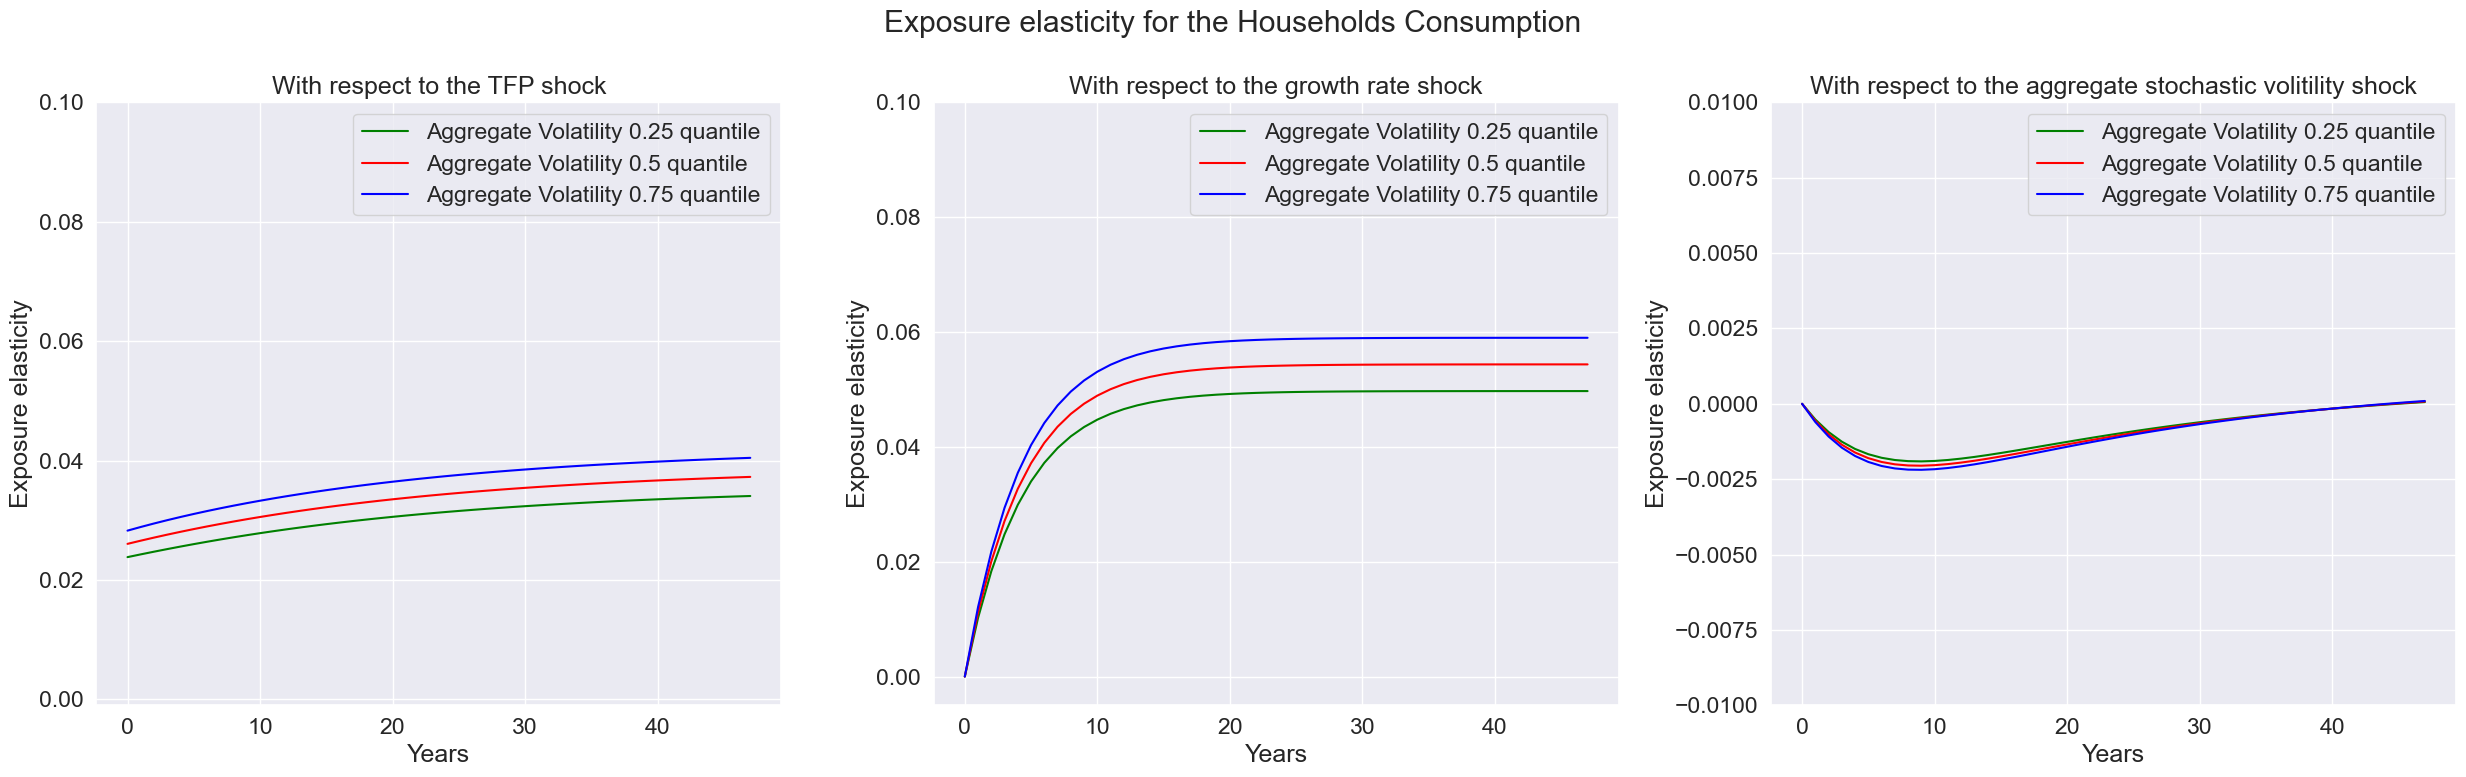

In [11]:
index = ['T','Aggregate Volatility 0.25 quantile','Aggregate Volatility 0.5 quantile','Aggregate Volatility 0.75 quantile']
fig, axes = plt.subplots(1,3, figsize = (25,8))
expo_elas_shock_0 = pd.DataFrame([np.arange(T),expoElasHouseholds.firstType[0,0,:],expoElasHouseholds.firstType[1,0,:],expoElasHouseholds.firstType[2,0,:]], index = index).T
expo_elas_shock_1 = pd.DataFrame([np.arange(T),expoElasHouseholds.firstType[0,1,:],expoElasHouseholds.firstType[1,1,:],expoElasHouseholds.firstType[2,1,:]], index = index).T
expo_elas_shock_2 = pd.DataFrame([np.arange(T),expoElasHouseholds.firstType[0,2,:],expoElasHouseholds.firstType[1,2,:],expoElasHouseholds.firstType[2,2,:]], index = index).T

n_qt = len(quantile)
plot_elas = [expo_elas_shock_0, expo_elas_shock_1, expo_elas_shock_2]
shock_name = ['TFP shock', 'growth rate shock', 'aggregate stochastic volitility shock']
qt = ['Aggregate Volatility 0.25 quantile','Aggregate Volatility 0.5 quantile','Aggregate Volatility 0.75 quantile']
colors = ['green','red','blue']

for i in range(len(plot_elas)):
    for j in range(n_qt):
        sns.lineplot(data = plot_elas[i],  x = 'T', y = qt[j], ax=axes[i], color = colors[j], label = qt[j])
        axes[i].set_xlabel('Years')
        axes[i].set_ylabel('Exposure elasticity')
        axes[i].set_title('With respect to the ' + shock_name[i])
axes[0].set_ylim([-0.001,0.1])
axes[1].set_ylim([-0.005,0.1])
axes[2].set_ylim([-0.01,0.01])
fig.suptitle('Exposure elasticity for the Households Consumption')
fig.tight_layout()
plt.show()

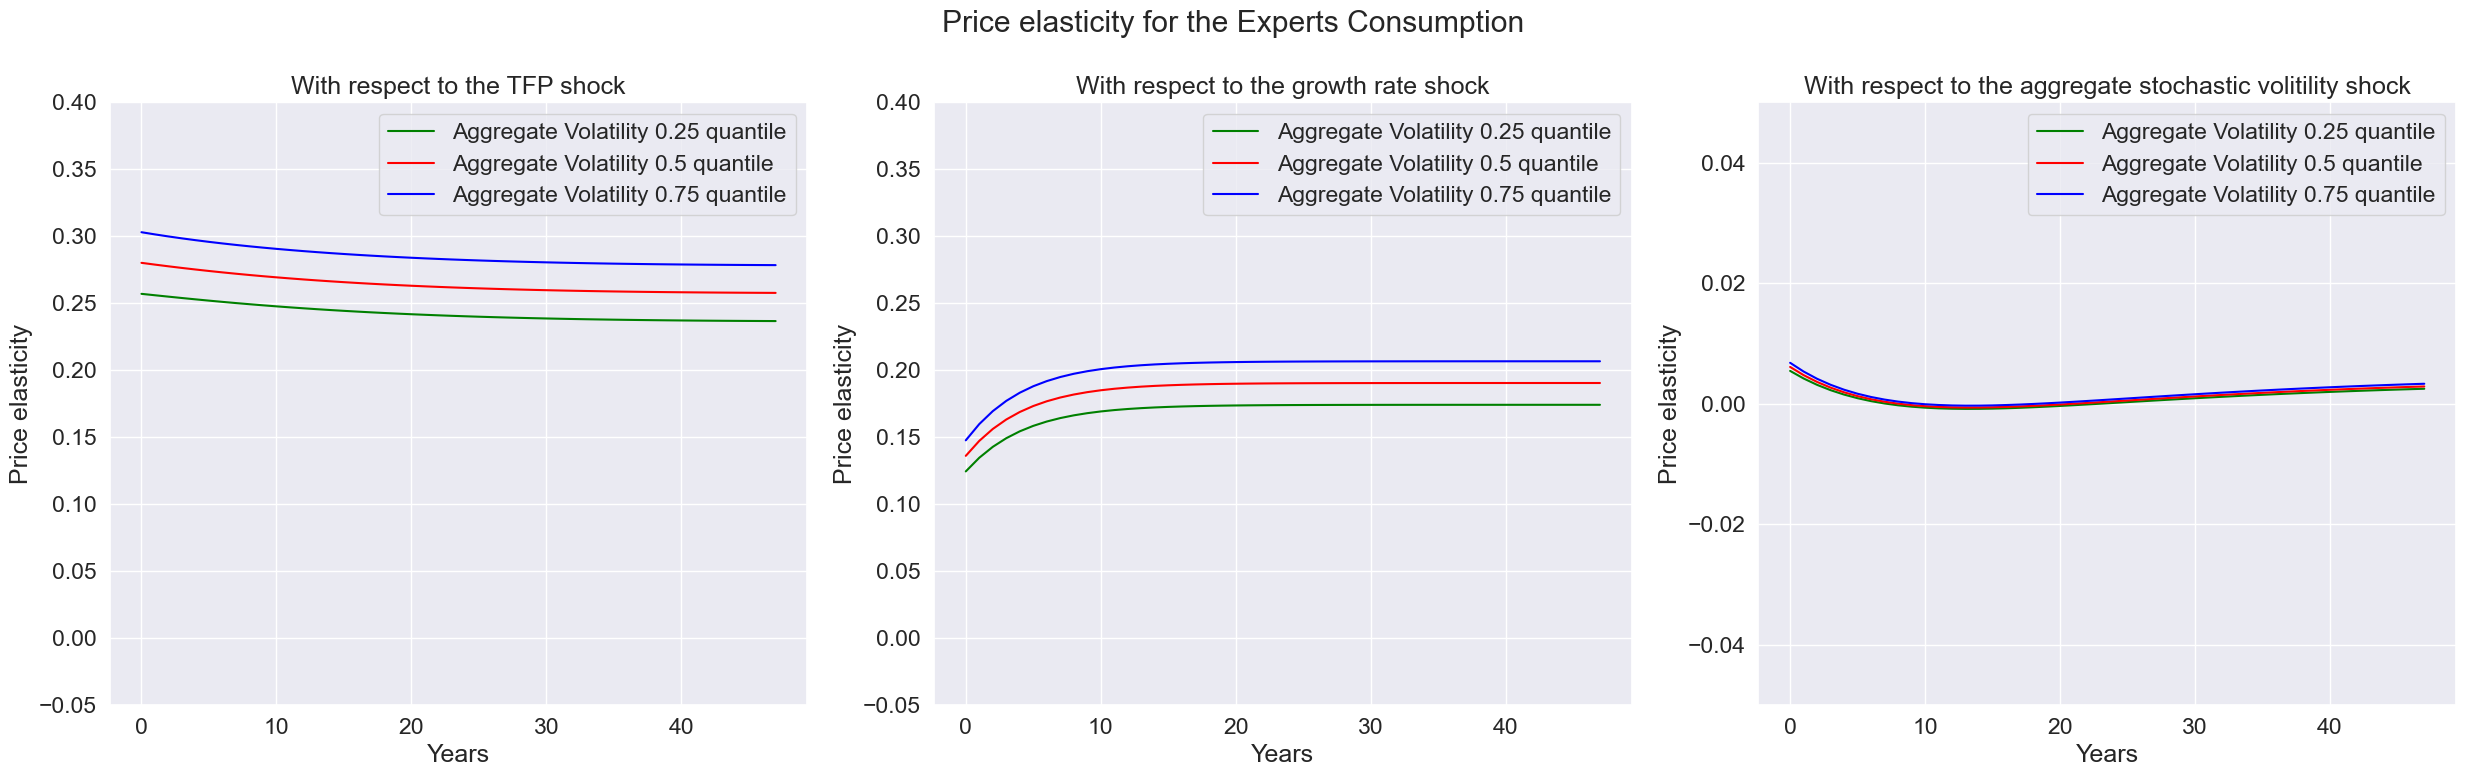

In [12]:
index = ['T','Aggregate Volatility 0.25 quantile','Aggregate Volatility 0.5 quantile','Aggregate Volatility 0.75 quantile']
fig, axes = plt.subplots(1,3, figsize = (25,8))
expo_elas_shock_0 = pd.DataFrame([np.arange(T),priceElasExperts.firstType[0,0,:],priceElasExperts.firstType[1,0,:],priceElasExperts.firstType[2,0,:]], index = index).T
expo_elas_shock_1 = pd.DataFrame([np.arange(T),priceElasExperts.firstType[0,1,:],priceElasExperts.firstType[1,1,:],priceElasExperts.firstType[2,1,:]], index = index).T
expo_elas_shock_2 = pd.DataFrame([np.arange(T),-priceElasExperts.firstType[0,2,:],-priceElasExperts.firstType[1,2,:],-priceElasExperts.firstType[2,2,:]], index = index).T

n_qt = len(quantile)
plot_elas = [expo_elas_shock_0, expo_elas_shock_1, expo_elas_shock_2]
shock_name = ['TFP shock', 'growth rate shock', 'aggregate stochastic volitility shock']
qt = ['Aggregate Volatility 0.25 quantile','Aggregate Volatility 0.5 quantile','Aggregate Volatility 0.75 quantile']
colors = ['green','red','blue']

for i in range(len(plot_elas)):
    for j in range(n_qt):
        sns.lineplot(data = plot_elas[i],  x = 'T', y = qt[j], ax=axes[i], color = colors[j], label = qt[j])
        axes[i].set_xlabel('Years')
        axes[i].set_ylabel('Price elasticity')
        axes[i].set_title('With respect to the ' + shock_name[i])
axes[0].set_ylim([-0.05,0.4])
axes[1].set_ylim([-0.05,0.4])
axes[2].set_ylim([-0.05,0.05])
fig.suptitle('Price elasticity for the Experts Consumption')
fig.tight_layout()
plt.show()

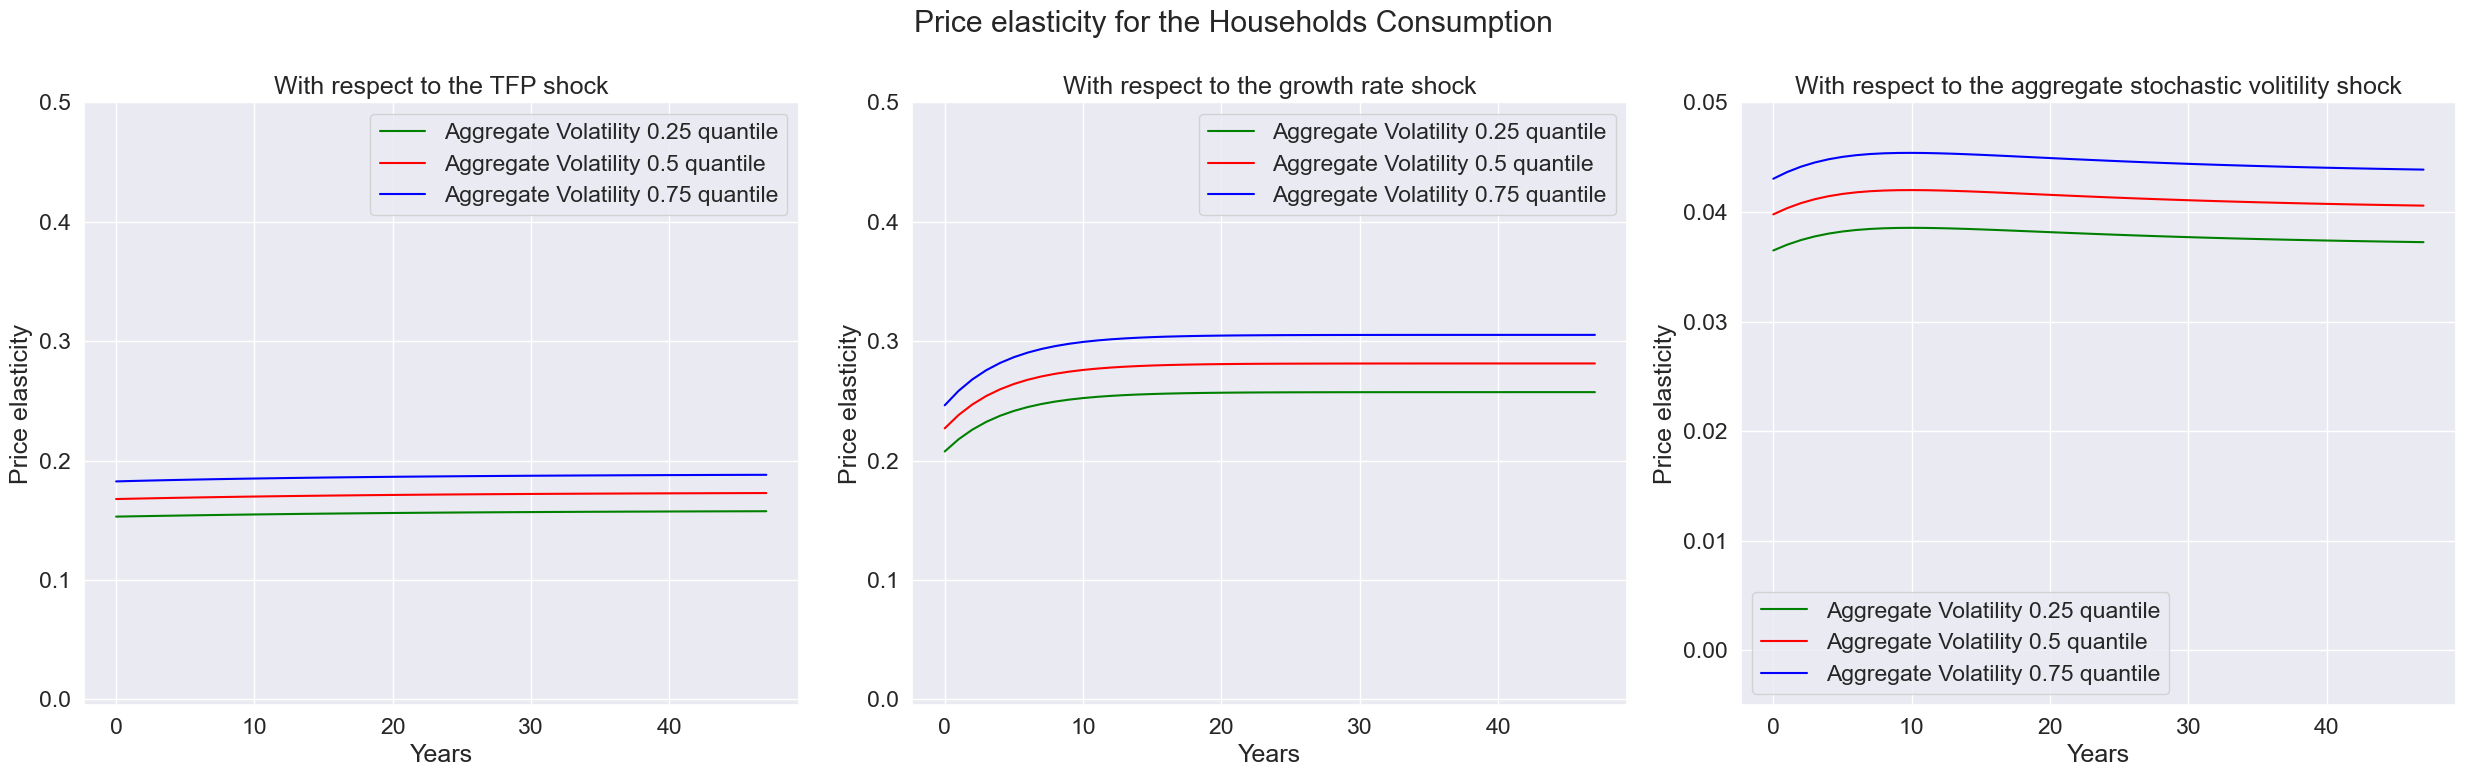

In [13]:
index = ['T','Aggregate Volatility 0.25 quantile','Aggregate Volatility 0.5 quantile','Aggregate Volatility 0.75 quantile']
fig, axes = plt.subplots(1,3, figsize = (25,8))
expo_elas_shock_0 = pd.DataFrame([np.arange(T),priceElasHouseholds.firstType[0,0,:],priceElasHouseholds.firstType[1,0,:],priceElasHouseholds.firstType[2,0,:]], index = index).T
expo_elas_shock_1 = pd.DataFrame([np.arange(T),priceElasHouseholds.firstType[0,1,:],priceElasHouseholds.firstType[1,1,:],priceElasHouseholds.firstType[2,1,:]], index = index).T
expo_elas_shock_2 = pd.DataFrame([np.arange(T),-priceElasHouseholds.firstType[0,2,:],-priceElasHouseholds.firstType[1,2,:],-priceElasHouseholds.firstType[2,2,:]], index = index).T

n_qt = len(quantile)
plot_elas = [expo_elas_shock_0, expo_elas_shock_1, expo_elas_shock_2]
shock_name = ['TFP shock', 'growth rate shock', 'aggregate stochastic volitility shock']
qt = ['Aggregate Volatility 0.25 quantile','Aggregate Volatility 0.5 quantile','Aggregate Volatility 0.75 quantile']
colors = ['green','red','blue']

for i in range(len(plot_elas)):
    for j in range(n_qt):
        sns.lineplot(data = plot_elas[i],  x = 'T', y = qt[j], ax=axes[i], color = colors[j], label = qt[j])
        axes[i].set_xlabel('Years')
        axes[i].set_ylabel('Price elasticity')
        axes[i].set_title('With respect to the ' + shock_name[i])
axes[0].set_ylim([-0.005,0.5])
axes[1].set_ylim([-0.005,0.5])
axes[2].set_ylim([-0.005,0.05])
fig.suptitle('Price elasticity for the Households Consumption')
fig.tight_layout()
plt.show()

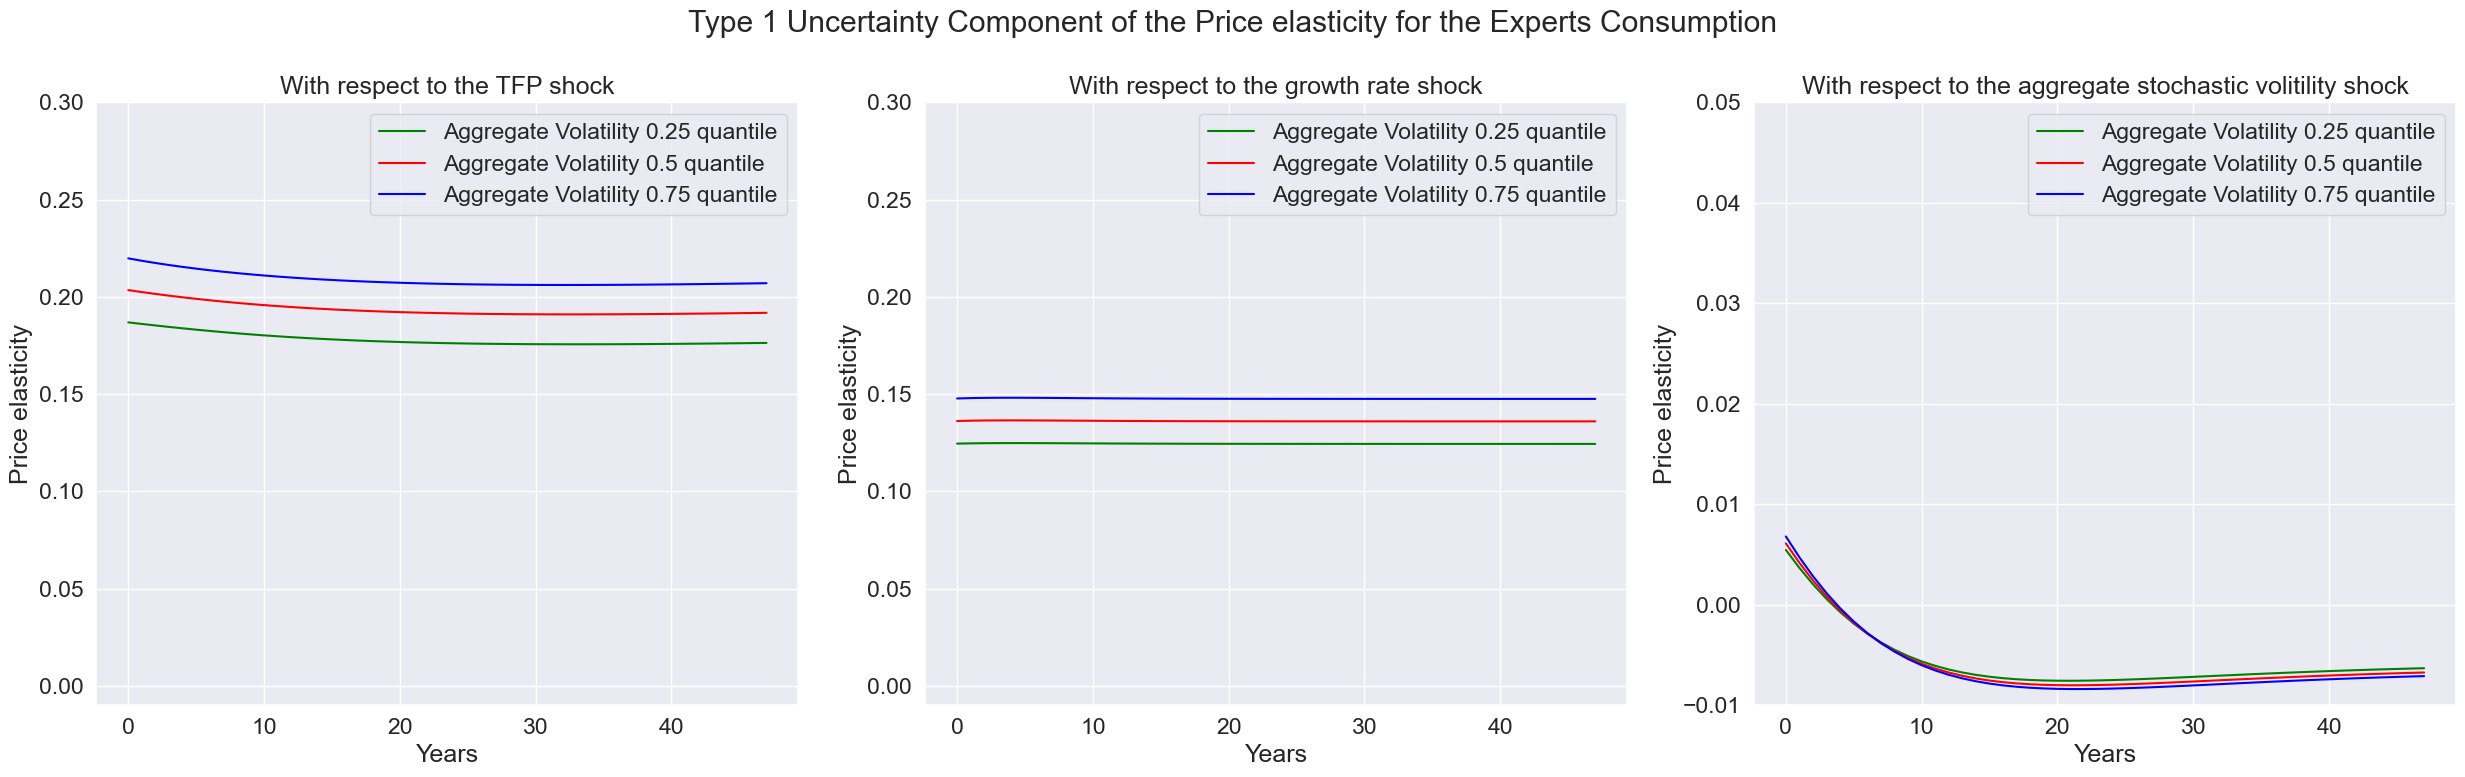

In [14]:
index = ['T','Aggregate Volatility 0.25 quantile','Aggregate Volatility 0.5 quantile','Aggregate Volatility 0.75 quantile']
fig, axes = plt.subplots(1,3, figsize = (25,8))
expo_elas_shock_0 = pd.DataFrame([np.arange(T),priceElasExpertsN.firstType[0,0,:],priceElasExpertsN.firstType[1,0,:],priceElasExpertsN.firstType[2,0,:]], index = index).T
expo_elas_shock_1 = pd.DataFrame([np.arange(T),priceElasExpertsN.firstType[0,1,:],priceElasExpertsN.firstType[1,1,:],priceElasExpertsN.firstType[2,1,:]], index = index).T
expo_elas_shock_2 = pd.DataFrame([np.arange(T),-priceElasExpertsN.firstType[0,2,:],-priceElasExpertsN.firstType[1,2,:],-priceElasExpertsN.firstType[2,2,:]], index = index).T

n_qt = len(quantile)
plot_elas = [expo_elas_shock_0, expo_elas_shock_1, expo_elas_shock_2]
shock_name = ['TFP shock', 'growth rate shock', 'aggregate stochastic volitility shock']
qt = ['Aggregate Volatility 0.25 quantile','Aggregate Volatility 0.5 quantile','Aggregate Volatility 0.75 quantile']
colors = ['green','red','blue']

for i in range(len(plot_elas)):
    for j in range(n_qt):
        sns.lineplot(data = plot_elas[i],  x = 'T', y = qt[j], ax=axes[i], color = colors[j], label = qt[j])
        axes[i].set_xlabel('Years')
        axes[i].set_ylabel('Price elasticity')
        axes[i].set_title('With respect to the ' + shock_name[i])
axes[0].set_ylim([-0.01,0.3])
axes[1].set_ylim([-0.01,0.3])
axes[2].set_ylim([-0.01,0.05])
fig.suptitle('Type 1 Uncertainty Component of the Price elasticity for the Experts Consumption')
fig.tight_layout()
plt.show()

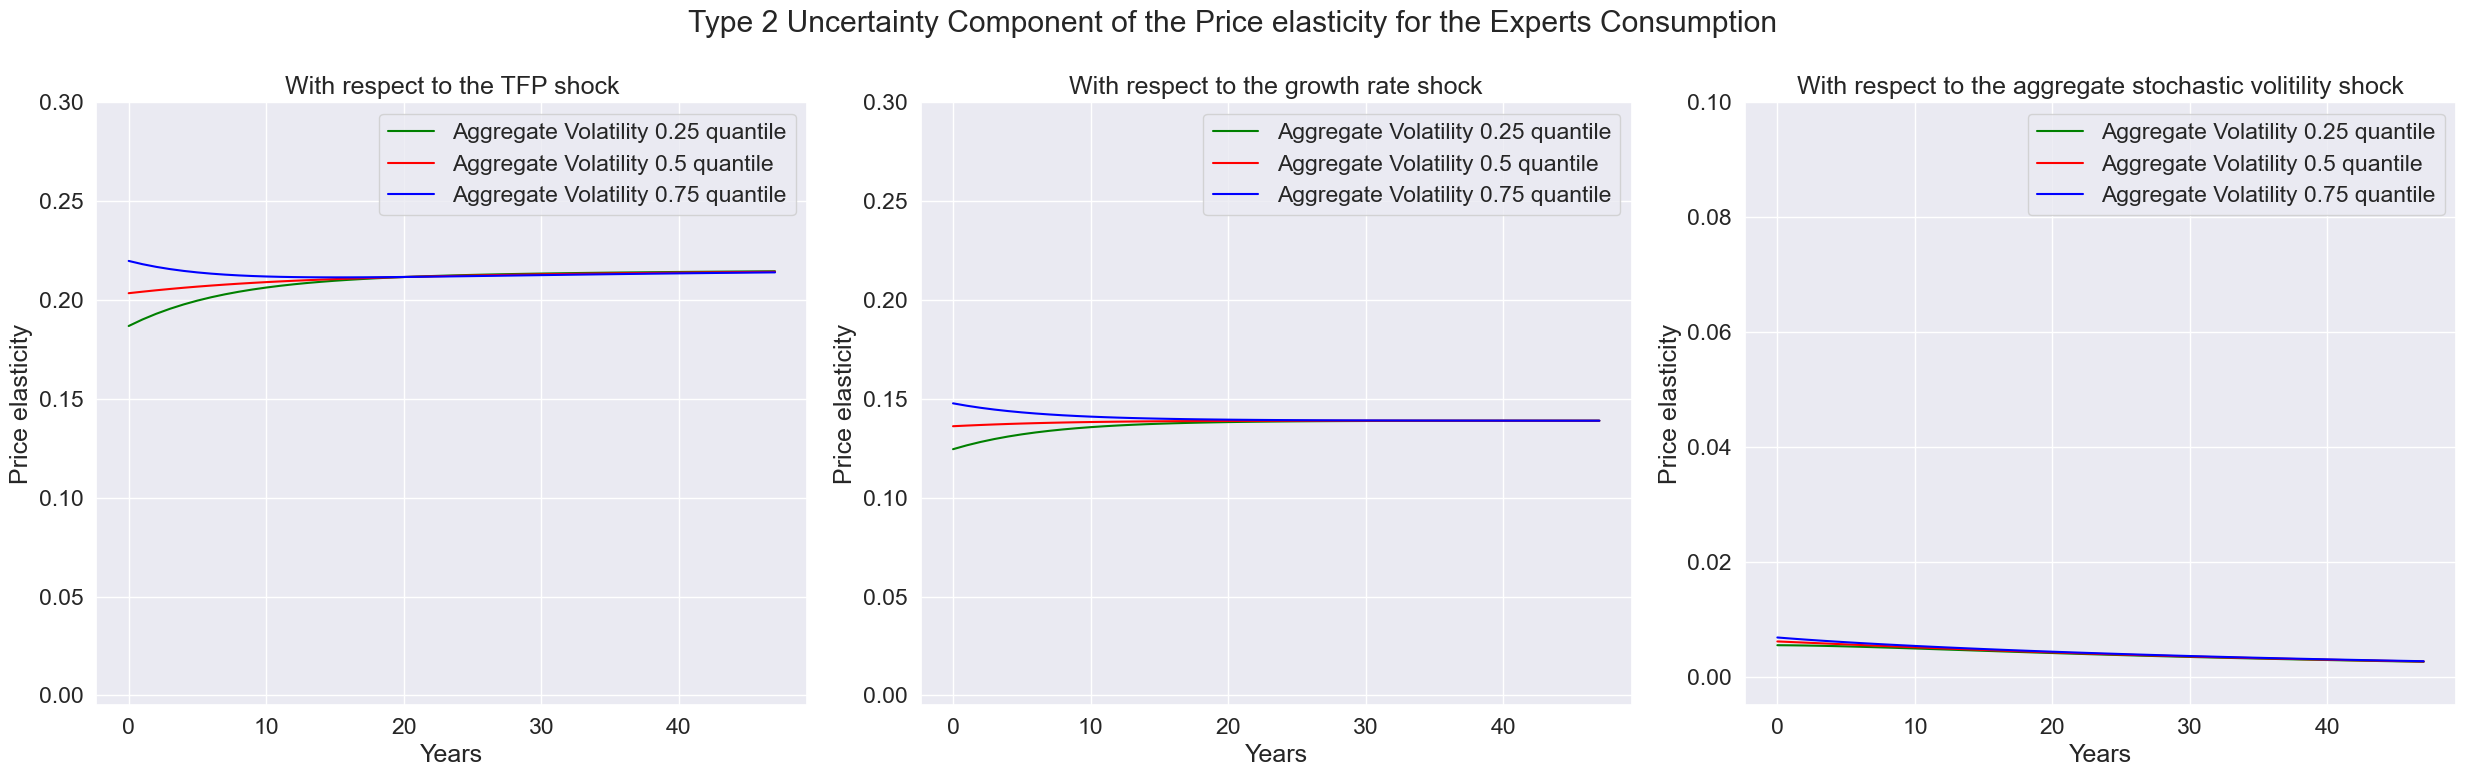

In [15]:
index = ['T','Aggregate Volatility 0.25 quantile','Aggregate Volatility 0.5 quantile','Aggregate Volatility 0.75 quantile']
fig, axes = plt.subplots(1,3, figsize = (25,8))
expo_elas_shock_0 = pd.DataFrame([np.arange(T),priceElasExpertsN.secondType[0,0,:],priceElasExpertsN.secondType[1,0,:],priceElasExpertsN.secondType[2,0,:]], index = index).T
expo_elas_shock_1 = pd.DataFrame([np.arange(T),priceElasExpertsN.secondType[0,1,:],priceElasExpertsN.secondType[1,1,:],priceElasExpertsN.secondType[2,1,:]], index = index).T
expo_elas_shock_2 = pd.DataFrame([np.arange(T),-priceElasExpertsN.secondType[0,2,:],-priceElasExpertsN.secondType[1,2,:],-priceElasExpertsN.secondType[2,2,:]], index = index).T

n_qt = len(quantile)
plot_elas = [expo_elas_shock_0, expo_elas_shock_1, expo_elas_shock_2]
shock_name = ['TFP shock', 'growth rate shock', 'aggregate stochastic volitility shock']
qt = ['Aggregate Volatility 0.25 quantile','Aggregate Volatility 0.5 quantile','Aggregate Volatility 0.75 quantile']
colors = ['green','red','blue']

for i in range(len(plot_elas)):
    for j in range(n_qt):
        sns.lineplot(data = plot_elas[i],  x = 'T', y = qt[j], ax=axes[i], color = colors[j], label = qt[j])
        axes[i].set_xlabel('Years')
        axes[i].set_ylabel('Price elasticity')
        axes[i].set_title('With respect to the ' + shock_name[i])
axes[0].set_ylim([-0.005,0.3])
axes[1].set_ylim([-0.005,0.3])
axes[2].set_ylim([-0.005,0.1])
fig.suptitle('Type 2 Uncertainty Component of the Price elasticity for the Experts Consumption')
fig.tight_layout()
plt.show()

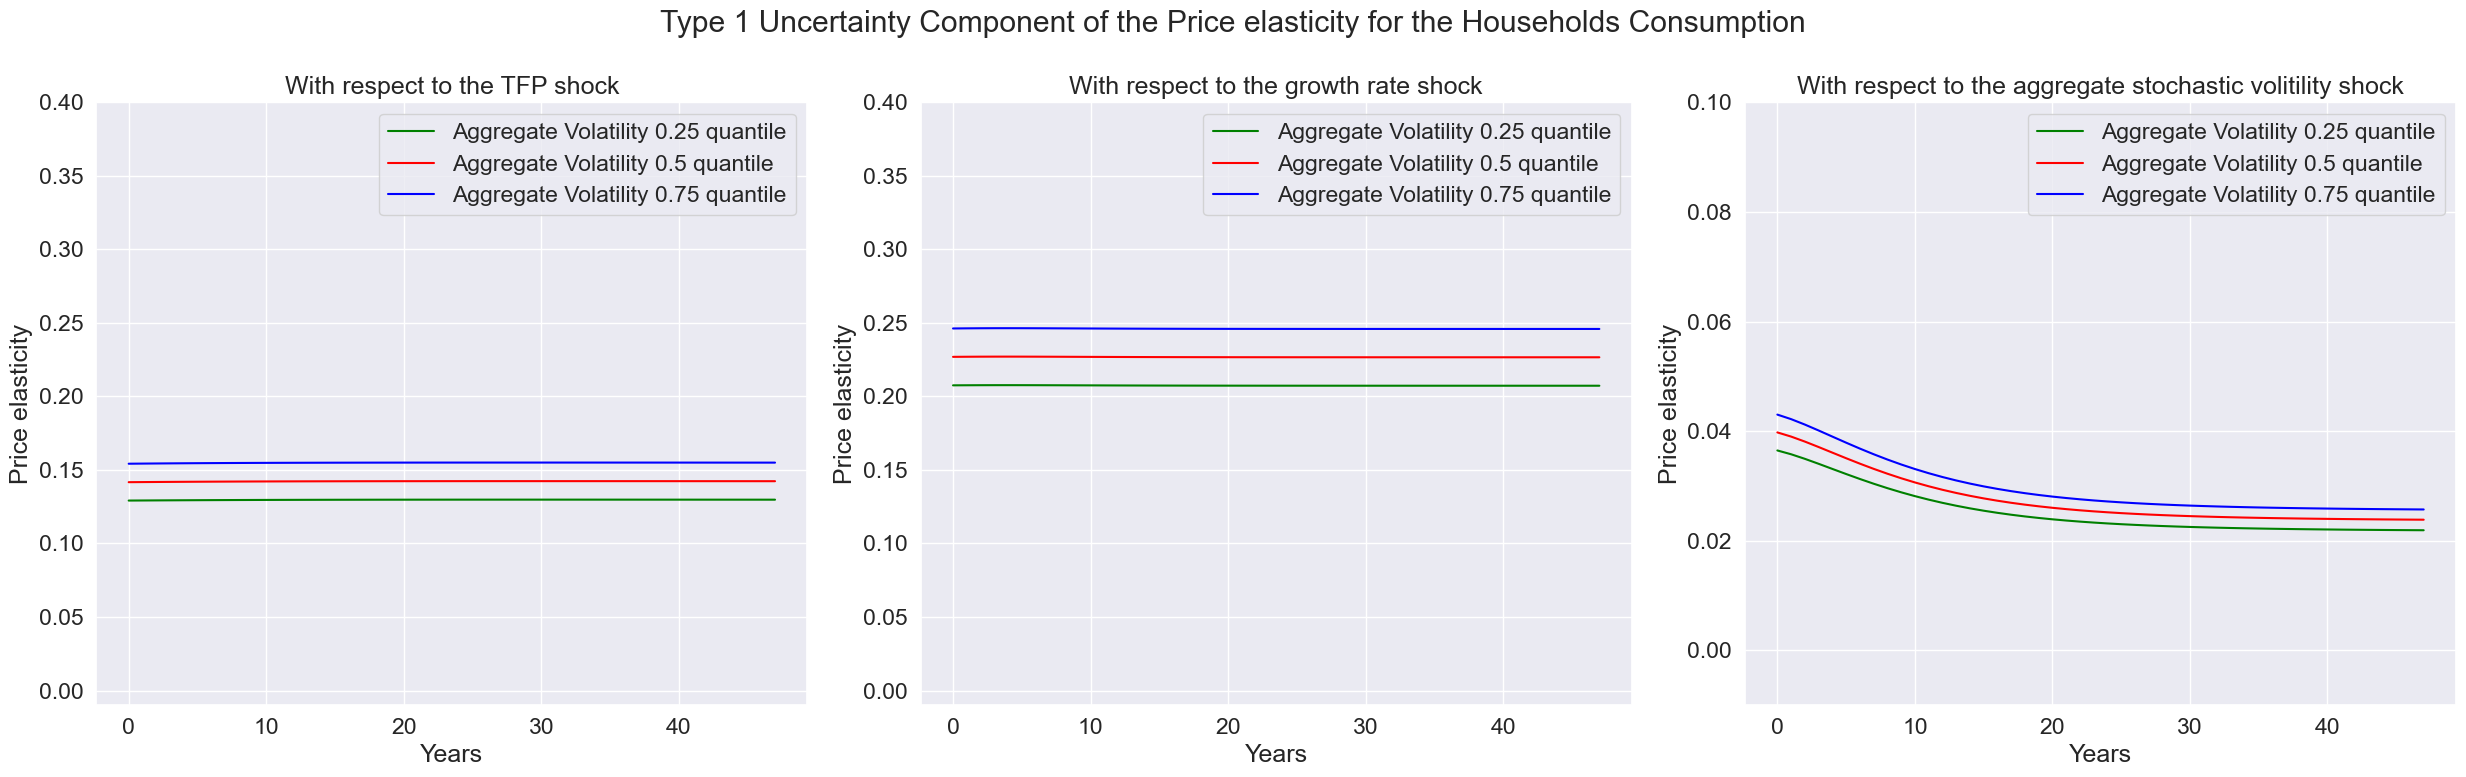

In [16]:
index = ['T','Aggregate Volatility 0.25 quantile','Aggregate Volatility 0.5 quantile','Aggregate Volatility 0.75 quantile']
fig, axes = plt.subplots(1,3, figsize = (25,8))
expo_elas_shock_0 = pd.DataFrame([np.arange(T),priceElasHouseholdsN.firstType[0,0,:],priceElasHouseholdsN.firstType[1,0,:],priceElasHouseholdsN.firstType[2,0,:]], index = index).T
expo_elas_shock_1 = pd.DataFrame([np.arange(T),priceElasHouseholdsN.firstType[0,1,:],priceElasHouseholdsN.firstType[1,1,:],priceElasHouseholdsN.firstType[2,1,:]], index = index).T
expo_elas_shock_2 = pd.DataFrame([np.arange(T),-priceElasHouseholdsN.firstType[0,2,:],-priceElasHouseholdsN.firstType[1,2,:],-priceElasHouseholdsN.firstType[2,2,:]], index = index).T

n_qt = len(quantile)
plot_elas = [expo_elas_shock_0, expo_elas_shock_1, expo_elas_shock_2]
shock_name = ['TFP shock', 'growth rate shock', 'aggregate stochastic volitility shock']
qt = ['Aggregate Volatility 0.25 quantile','Aggregate Volatility 0.5 quantile','Aggregate Volatility 0.75 quantile']
colors = ['green','red','blue']

for i in range(len(plot_elas)):
    for j in range(n_qt):
        sns.lineplot(data = plot_elas[i],  x = 'T', y = qt[j], ax=axes[i], color = colors[j], label = qt[j])
        axes[i].set_xlabel('Years')
        axes[i].set_ylabel('Price elasticity')
        axes[i].set_title('With respect to the ' + shock_name[i])
axes[0].set_ylim([-0.01,0.4])
axes[1].set_ylim([-0.01,0.4])
axes[2].set_ylim([-0.01,0.1])
fig.suptitle('Type 1 Uncertainty Component of the Price elasticity for the Households Consumption')
fig.tight_layout()
plt.show()

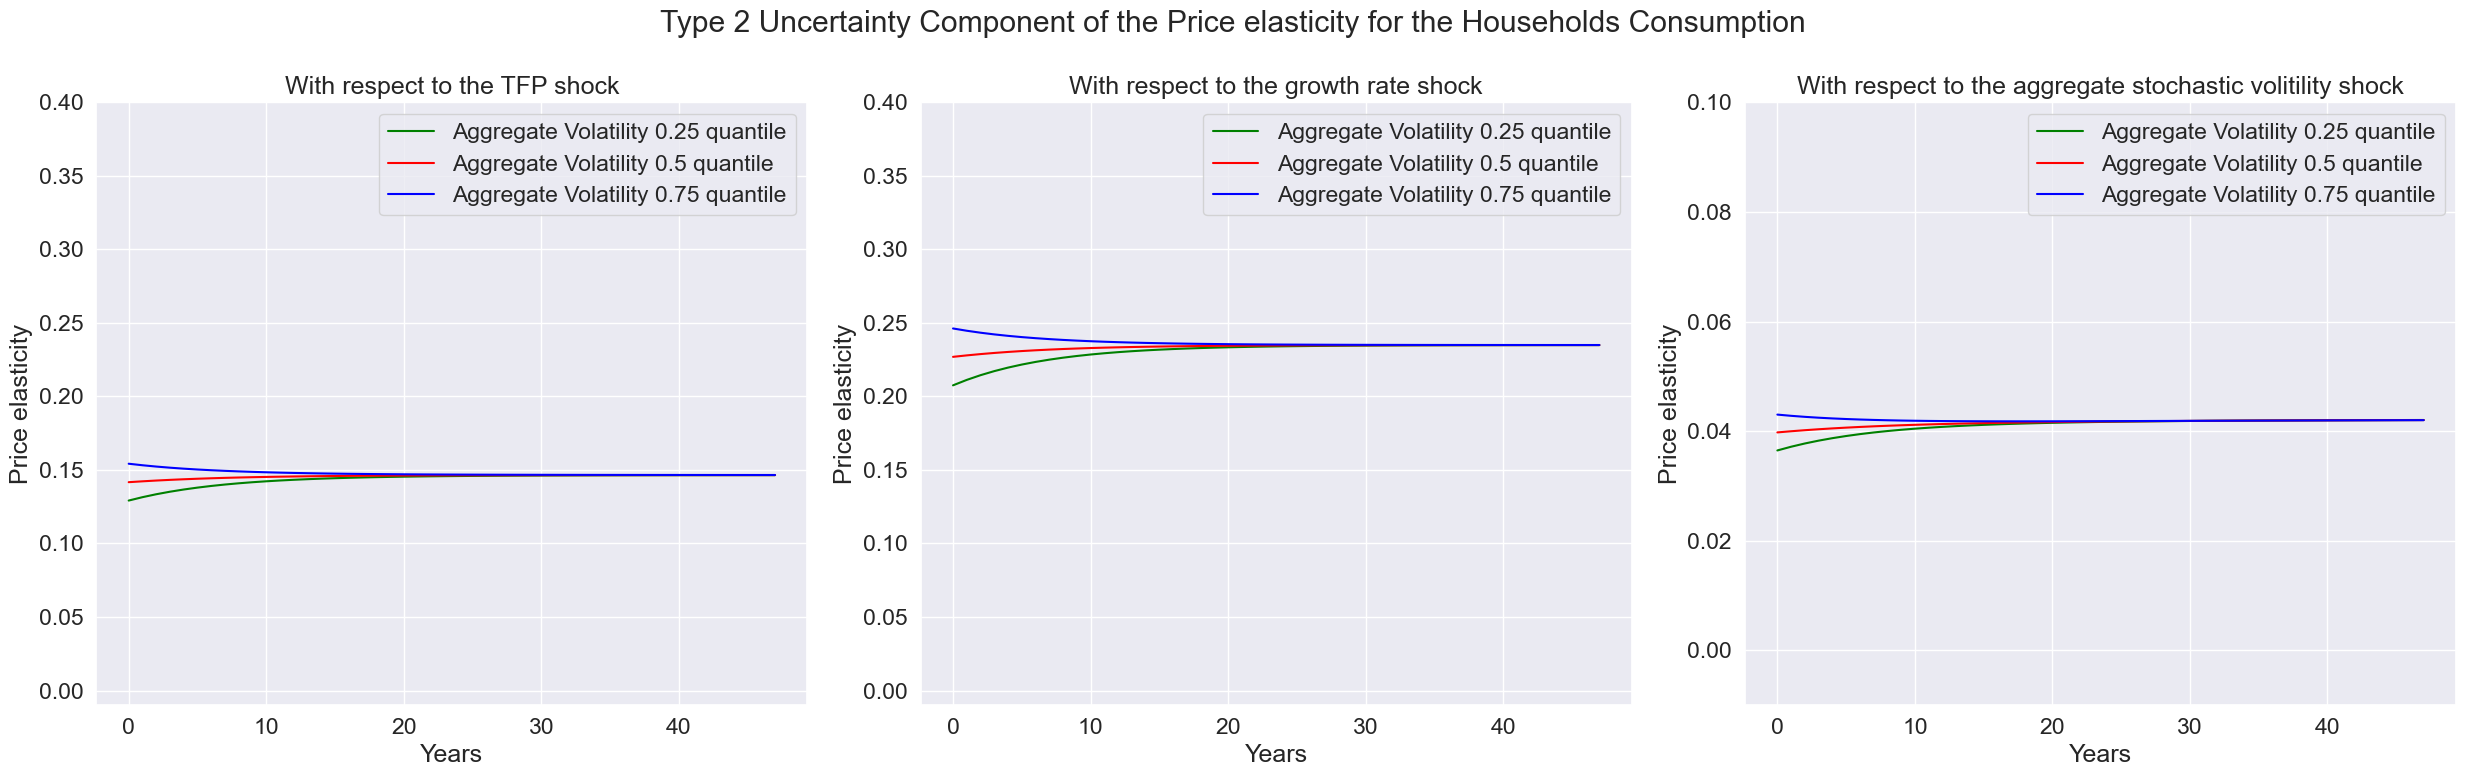

In [17]:
index = ['T','Aggregate Volatility 0.25 quantile','Aggregate Volatility 0.5 quantile','Aggregate Volatility 0.75 quantile']
fig, axes = plt.subplots(1,3, figsize = (25,8))
expo_elas_shock_0 = pd.DataFrame([np.arange(T),priceElasHouseholdsN.secondType[0,0,:],priceElasHouseholdsN.secondType[1,0,:],priceElasHouseholdsN.secondType[2,0,:]], index = index).T
expo_elas_shock_1 = pd.DataFrame([np.arange(T),priceElasHouseholdsN.secondType[0,1,:],priceElasHouseholdsN.secondType[1,1,:],priceElasHouseholdsN.secondType[2,1,:]], index = index).T
expo_elas_shock_2 = pd.DataFrame([np.arange(T),-priceElasHouseholdsN.secondType[0,2,:],-priceElasHouseholdsN.secondType[1,2,:],-priceElasHouseholdsN.secondType[2,2,:]], index = index).T

n_qt = len(quantile)
plot_elas = [expo_elas_shock_0, expo_elas_shock_1, expo_elas_shock_2]
shock_name = ['TFP shock', 'growth rate shock', 'aggregate stochastic volitility shock']
qt = ['Aggregate Volatility 0.25 quantile','Aggregate Volatility 0.5 quantile','Aggregate Volatility 0.75 quantile']
colors = ['green','red','blue']

for i in range(len(plot_elas)):
    for j in range(n_qt):
        sns.lineplot(data = plot_elas[i],  x = 'T', y = qt[j], ax=axes[i], color = colors[j], label = qt[j])
        axes[i].set_xlabel('Years')
        axes[i].set_ylabel('Price elasticity')
        axes[i].set_title('With respect to the ' + shock_name[i])
axes[0].set_ylim([-0.01,0.4])
axes[1].set_ylim([-0.01,0.4])
axes[2].set_ylim([-0.01,0.1])
fig.suptitle('Type 2 Uncertainty Component of the Price elasticity for the Households Consumption')
fig.tight_layout()
plt.show()

# Reference

[1] Borovička, Jaroslav, Lars Peter Hansen, and José A. Scheinkman. "Shock elasticities and impulse responses." Mathematics and Financial Economics 8 (2014): 333-354.

[2] Hansen, Lars Peter. "Dynamic valuation decomposition within stochastic economies." Econometrica 80, no. 3 (2012): 911-967.

[3], Brunnermeier, Markus K., and Yuliy Sannikov. "A macroeconomic model with a financial sector." American Economic Review 104, no. 2 (2014): 379-421.

[4] Brunnermeier, Markus K., and Yuliy Sannikov. "Macro, money, and finance: A continuous-time approach." In Handbook of Macroeconomics, vol. 2, pp. 1497-1545. Elsevier, 2016.

[5] Hansen, Lars Peter, Paymon Khorrami, and Fabrice Tourre. Comparative valuation dynamics in models with financing restrictions. Working Paper, 2018.